In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import pandas as pd
import json
import os
import re
import sys

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))

from eventdt.objects.exportable import Exportable
from multiplex import drawable

In [2]:
data_dir = os.path.expanduser("~/DATA/c3-apd/ner/")
events = [ '#SOUARS', '#LEIMUN', '#SCOCZE', '#TURITA', '#HUNFRA', '#WALSUI' ]

scores = { }
for event in events:
    with open(os.path.join(data_dir, f"{event}-twitterner.json"), 'r') as f:
        data = json.loads(''.join(f.readlines()))
        for ne in data['scored']:
            rank = int(ne['rank'])
            scores[rank] = scores.get(rank, 0) + ne['score']

scores = { rank: score / len(events) for rank, score in scores.items() }

In [3]:
items = list(scores.items())
flattened = { }
flattened['rank'] = [ item[0] for item in items ]
flattened['score'] = [ item[1] for item in items ]

df = pd.DataFrame.from_dict(flattened)
df = df.set_index('rank')
df['zipf'] = [ rank**-1.2 for rank in df.index ]
df.head(10)

,score,zipf
rank,,
1,1.000000,1.000000
2,0.512361,0.435275
3,0.171722,0.267581
4,0.151013,0.189465
5,0.123988,0.144956
6,0.101266,0.116471
7,0.084404,0.096802
8,0.075845,0.082469
9,0.068575,0.071599


More on [Power law distribution](https://wiki.analytica.com/index.php?title=Power_law_distribution) (with [log on both sides](https://www.physics.brocku.ca/PPLATO/interactive-mathematics/loglog2.html#:~:text=take%20logs%20of%20both%20sides))

[Primer](https://necsi.edu/power-law)

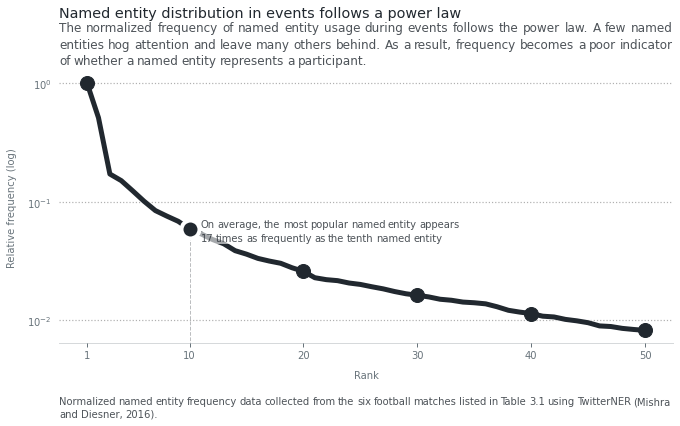

In [4]:
# prepare the data
limit = 50
scores = df.score[:limit]
theoretical = df.zipf[:limit]
x = range(1, limit+1)

annotations = {
    10: f"On average, the most popular named entity appears { round(1/df.loc[10].score) } times as frequently as the tenth named entity",
}

# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99',
                     'lineheight': 0.4, 'pad': 1 }

# draw the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)
# viz.draw_time_series(x, theoretical, color='C5', **style)
viz.draw_time_series(x, scores, color='C0', **style)
viz.scatter([ 1 ] + list(x[9::10]), [ scores[1] ] + list(scores[9::10]), color='C0', **scatter_style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in annotations.items():
    y = df.loc[x].score
    viz.vlines(x, ymin=ylim[0], ymax=y, **line_style)
    viz.plot(x, y, color='C0', **annotation_marker_style)
    viz.annotate(label, (x, x+25), y, **annotation_style)

# finalize the visualization
# viz.set_xscale('log')
viz.set_xticks([ 1 ] + list(range(10, limit+1, 10)))
viz.set_xlabel('Rank')
viz.set_yscale('log')
viz.set_ylabel('Relative frequency (log)')
viz.set_axisbelow(True)

# add the title and captions
viz.set_title("Named entity distribution in events follows a power law", loc='left')
viz.set_caption(f"""The normalized frequency of named entity usage during events follows the power law.
                    A few named entities hog attention and leave many others behind.
                    As a result, frequency becomes a poor indicator of whether a named entity represents a participant.""",
                 align='justify')
viz.set_footnote("Normalized named entity frequency data collected from the six football matches listed in Table 3.1 using TwitterNER (Mishra and Diesner, 2016).")
viz.savefig('../exports/3.2-named-entity-power-law.png', dpi=300, bbox_inches='tight')